In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# CSV functions
def csv_to_dict(file):
    """
    read CSV file and create dict with key for each head containing a list of column entries for respective head
    
    :param file: path to CSV file to read
    :return: created dictionary
    """
    d = {}
    with open(file) as fin:
        reader = csv.reader(fin)
        headers = next(reader, None)
        for h in headers:
            d[h] = []
        for row in reader:
            for h, entry in zip(headers,row):
                d[h].append(entry)
    return d


def print_csv_dict(d):
    """
    print CSV dictionary in formatted way
    
    :param d: dict of CSV file to print
    :return:
    """
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(d)

In [3]:
# IMU data dict functions
def extract_acc(d):
    """
    extract acceleration vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: a (numpy array)
    """
    a = np.array(d['a'], dtype='float32')
    return a

def extract_vel(d):
    """
    extract velocity vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: v (numpy array)
    """
    v = np.array(d['v'], dtype='float32')
    return v

def extract_pos(d):
    """
    extract position vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: p (numpy array)
    """
    p = np.array(d['d'], dtype='float32')
    return p

def extract_time(d):
    """
    extract time vector for IMU data run dict (in seconds)
    
    :param d: dict of CSV file of IMU data run
    :return: time
    """
    timestamps = np.array(d['t'], dtype='float32')
    return timestamps

In [4]:
# read all data files for multi filter transformation stationary test
data_filter_sta = []
for run in range(5):
    run_name = 'run' + str(run + 1)
    run_data_file = 'stationary_tests/filtering_1d_transformation_multi/4imus/sta_4imus_filtermulti_' + run_name + '.csv'
    run_dict = csv_to_dict(run_data_file)
    data_filter_sta.append(run_dict)
    
# read all data files for no filter stationary test
data_nofilter_sta = []
for run in range(5):
    run_name = 'run' + str(run + 1)
    run_data_file = 'stationary_tests/no_filtering/4imus/sta_4imus_nofilter_' + run_name + '.csv'
    run_dict = csv_to_dict(run_data_file)
    data_nofilter_sta.append(run_dict)

In [5]:
def plot_drift_data(run_dicts):
    num = len(run_dicts)
    
    vels = []
    poss = []
    times = []
    for run_dict in run_dicts:
        vels.append(extract_vel(run_dict))
        poss.append(extract_pos(run_dict))
        times.append(extract_time(run_dict))
    
    f, axarr = plt.subplots(2, 2, figsize=(30,30))
    
    # plot vel errors over time
    for i in range(num):
        axarr[0, 0].plot(times[i], np.absolute(vels[i]))
        axarr[0, 0].set_xlabel('time [s]', fontsize=25)
        axarr[0, 0].set_ylabel('velocity error [m/s]', fontsize=25)
        axarr[0, 0].tick_params(axis='both', which='major', labelsize=20)
        
    # plot vel drift over time
    for i in range(num):
        axarr[0, 1].plot(times[i], np.absolute(vels[i] / times[i]))
        axarr[0, 1].set_xlabel('time [s]', fontsize=25)
        axarr[0, 1].set_ylabel('velocity drift [m/s^2]', fontsize=25)
        axarr[0, 1].tick_params(axis='both', which='major', labelsize=20)

    # plot pos errors over time
    for i in range(num):
        axarr[1, 0].plot(times[i], np.absolute(poss[i]))
        axarr[1, 0].set_xlabel('time [s]', fontsize=25)
        axarr[1, 0].set_ylabel('displacement error [m]', fontsize=25)
        axarr[1, 0].tick_params(axis='both', which='major', labelsize=20)
        
    # plot vel drift over time
    for i in range(num):
        axarr[1, 1].plot(times[i], np.absolute(poss[i] / times[i]))
        axarr[1, 1].set_xlabel('time [s]', fontsize=25)
        axarr[1, 1].set_ylabel('displacement drift [m/s]', fontsize=25)
        axarr[1, 1].tick_params(axis='both', which='major', labelsize=20)
    
    plt.show()

In [6]:
def plot_drift_data_average(run_dicts_lists):
    f, axarr = plt.subplots(2, 2, figsize=(30,30))
    
    min_lengths = []
    for run_dicts in run_dicts_lists:
        min_length = None
        for run_dict in run_dicts:
            acc = extract_acc(run_dict)
            if min_length is None or len(acc) < min_length:
                min_length = len(acc)
        min_lengths.append(min_length)
    
    avg_vel_err = []
    
    # plot vel errors over time
    for i, run_dicts in enumerate(run_dicts_lists):
        vels = []
        times = []
        for run_dict in run_dicts:
            vels.append(np.absolute(extract_vel(run_dict)[:min_lengths[i]]))
            times.append(extract_time(run_dict)[:min_lengths[i]])
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
            
        avg_time = np.mean(times, axis=0)
        avg_vel = np.mean(vels, axis=0)
        avg_vel_err.append([avg_time, avg_vel])
        
        axarr[0, 0].plot(avg_time, avg_vel, label=l)
        axarr[0, 0].set_xlabel('time [s]', fontsize=25)
        axarr[0, 0].set_ylabel('velocity error [m/s]', fontsize=25)
        axarr[0, 0].tick_params(axis='both', which='major', labelsize=20)
        axarr[0, 0].legend(prop={'size': 20})
        
    avg_vel_dri = []
    
    # plot vel drift over time
    for i, run_dicts in enumerate(run_dicts_lists):
        vals = []
        times = []
        for run_dict in run_dicts:
            vel = extract_vel(run_dict)[:min_lengths[i]]
            time = extract_time(run_dict)[:min_lengths[i]]
            vals.append(np.absolute(vel/time))
            times.append(time)
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
        
        avg_time = np.mean(times, axis=0)
        avg_vel_drift = np.mean(vals, axis=0)
        avg_vel_dri.append([avg_time, avg_vel_drift])
        
        axarr[0, 1].plot(avg_time, avg_vel_drift, label=l)
        axarr[0, 1].set_xlabel('time [s]', fontsize=25)
        axarr[0, 1].set_ylabel('velocity drift [m/s^2]', fontsize=25)
        axarr[0, 1].tick_params(axis='both', which='major', labelsize=20)
        axarr[0, 1].legend(prop={'size': 20})

    avg_pos_err = []
        
    # plot pos errors over time
    for i, run_dicts in enumerate(run_dicts_lists):
        poss = []
        times = []
        for run_dict in run_dicts:
            poss.append(np.absolute(extract_pos(run_dict)[:min_lengths[i]]))
            times.append(extract_time(run_dict)[:min_lengths[i]])
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
        
        avg_time = np.mean(times, axis=0)
        avg_pos = np.mean(poss, axis=0)
        avg_pos_err.append([avg_time, avg_pos])
        
        axarr[1, 0].plot(avg_time, avg_pos, label=l)
        axarr[1, 0].set_xlabel('time [s]', fontsize=25)
        axarr[1, 0].set_ylabel('displacement error [m]', fontsize=25)
        axarr[1, 0].tick_params(axis='both', which='major', labelsize=20)
        axarr[1, 0].legend(prop={'size': 20})
        
    avg_pos_dri = []
        
    # plot vel drift over time
    for i, run_dicts in enumerate(run_dicts_lists):
        vals = []
        times = []
        for run_dict in run_dicts:
            pos = extract_pos(run_dict)[:min_lengths[i]]
            time = extract_time(run_dict)[:min_lengths[i]]
            vals.append(np.absolute(pos/time))
            times.append(time)
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
            
        avg_time = np.mean(times, axis=0)
        avg_pos_drift = np.mean(vals, axis=0)
        avg_pos_dri.append([avg_time, avg_pos_drift])
            
        axarr[1, 1].plot(avg_time, avg_pos_drift, label=l)
        axarr[1, 1].set_xlabel('time [s]', fontsize=25)
        axarr[1, 1].set_ylabel('displacement drift [m/s]', fontsize=25)
        axarr[1, 1].tick_params(axis='both', which='major', labelsize=20)
        axarr[1, 1].legend(prop={'size': 20})
    
    plt.show()
    return avg_vel_err, avg_vel_dri, avg_pos_err, avg_pos_dri

Drift for stationary experiment WITHOUT filtering


/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


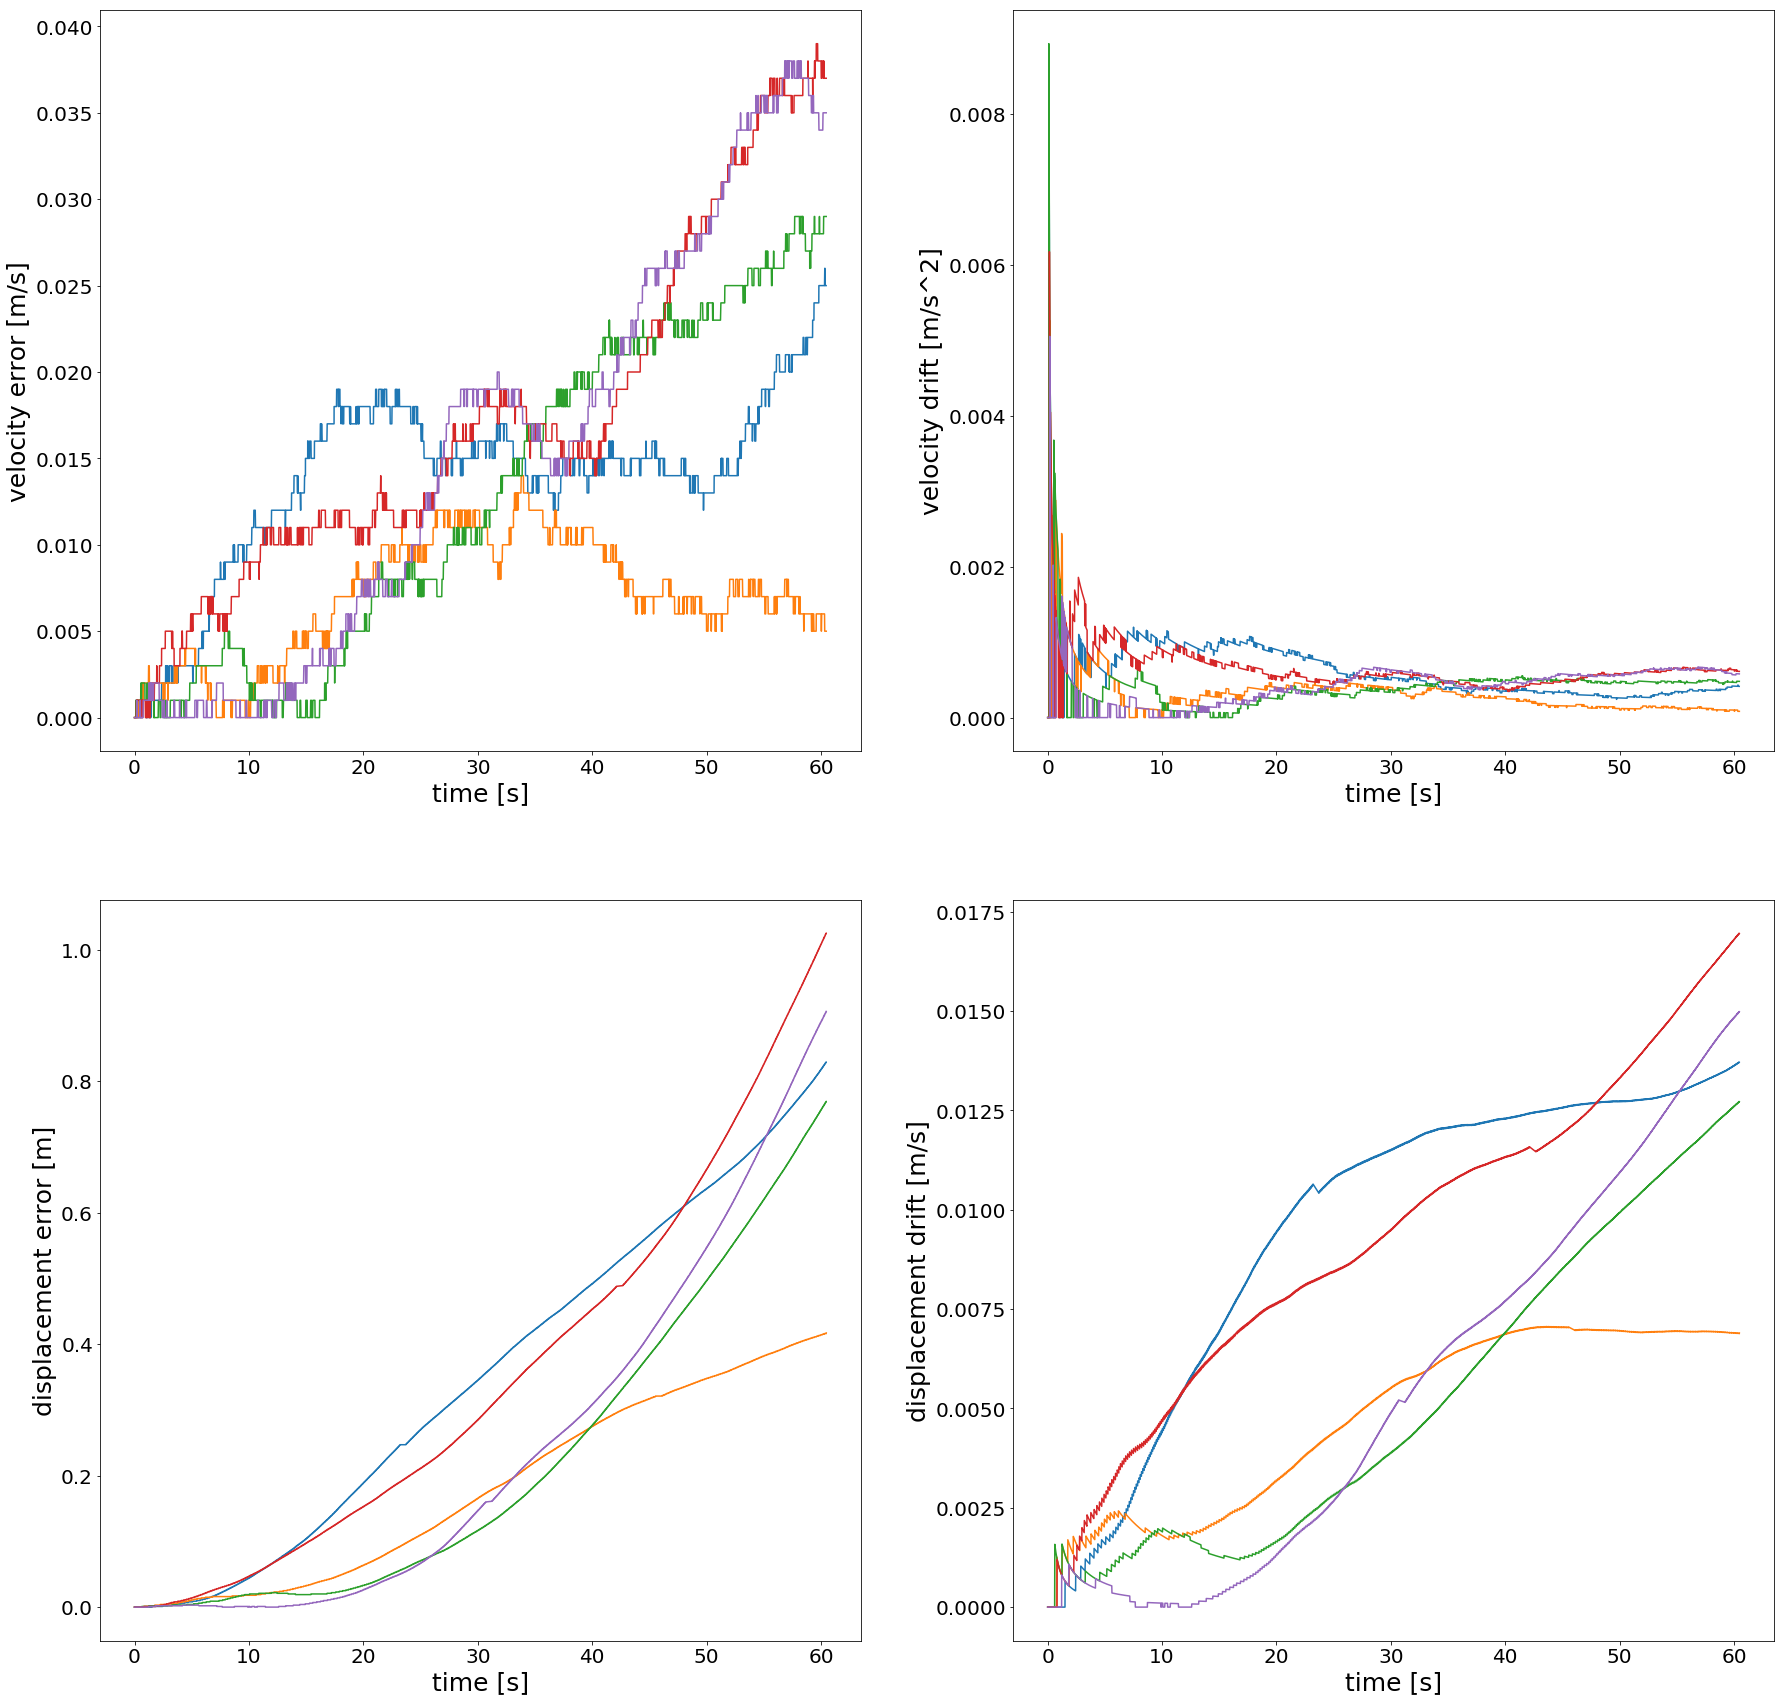

Drift for stationary experiment WITH filtering


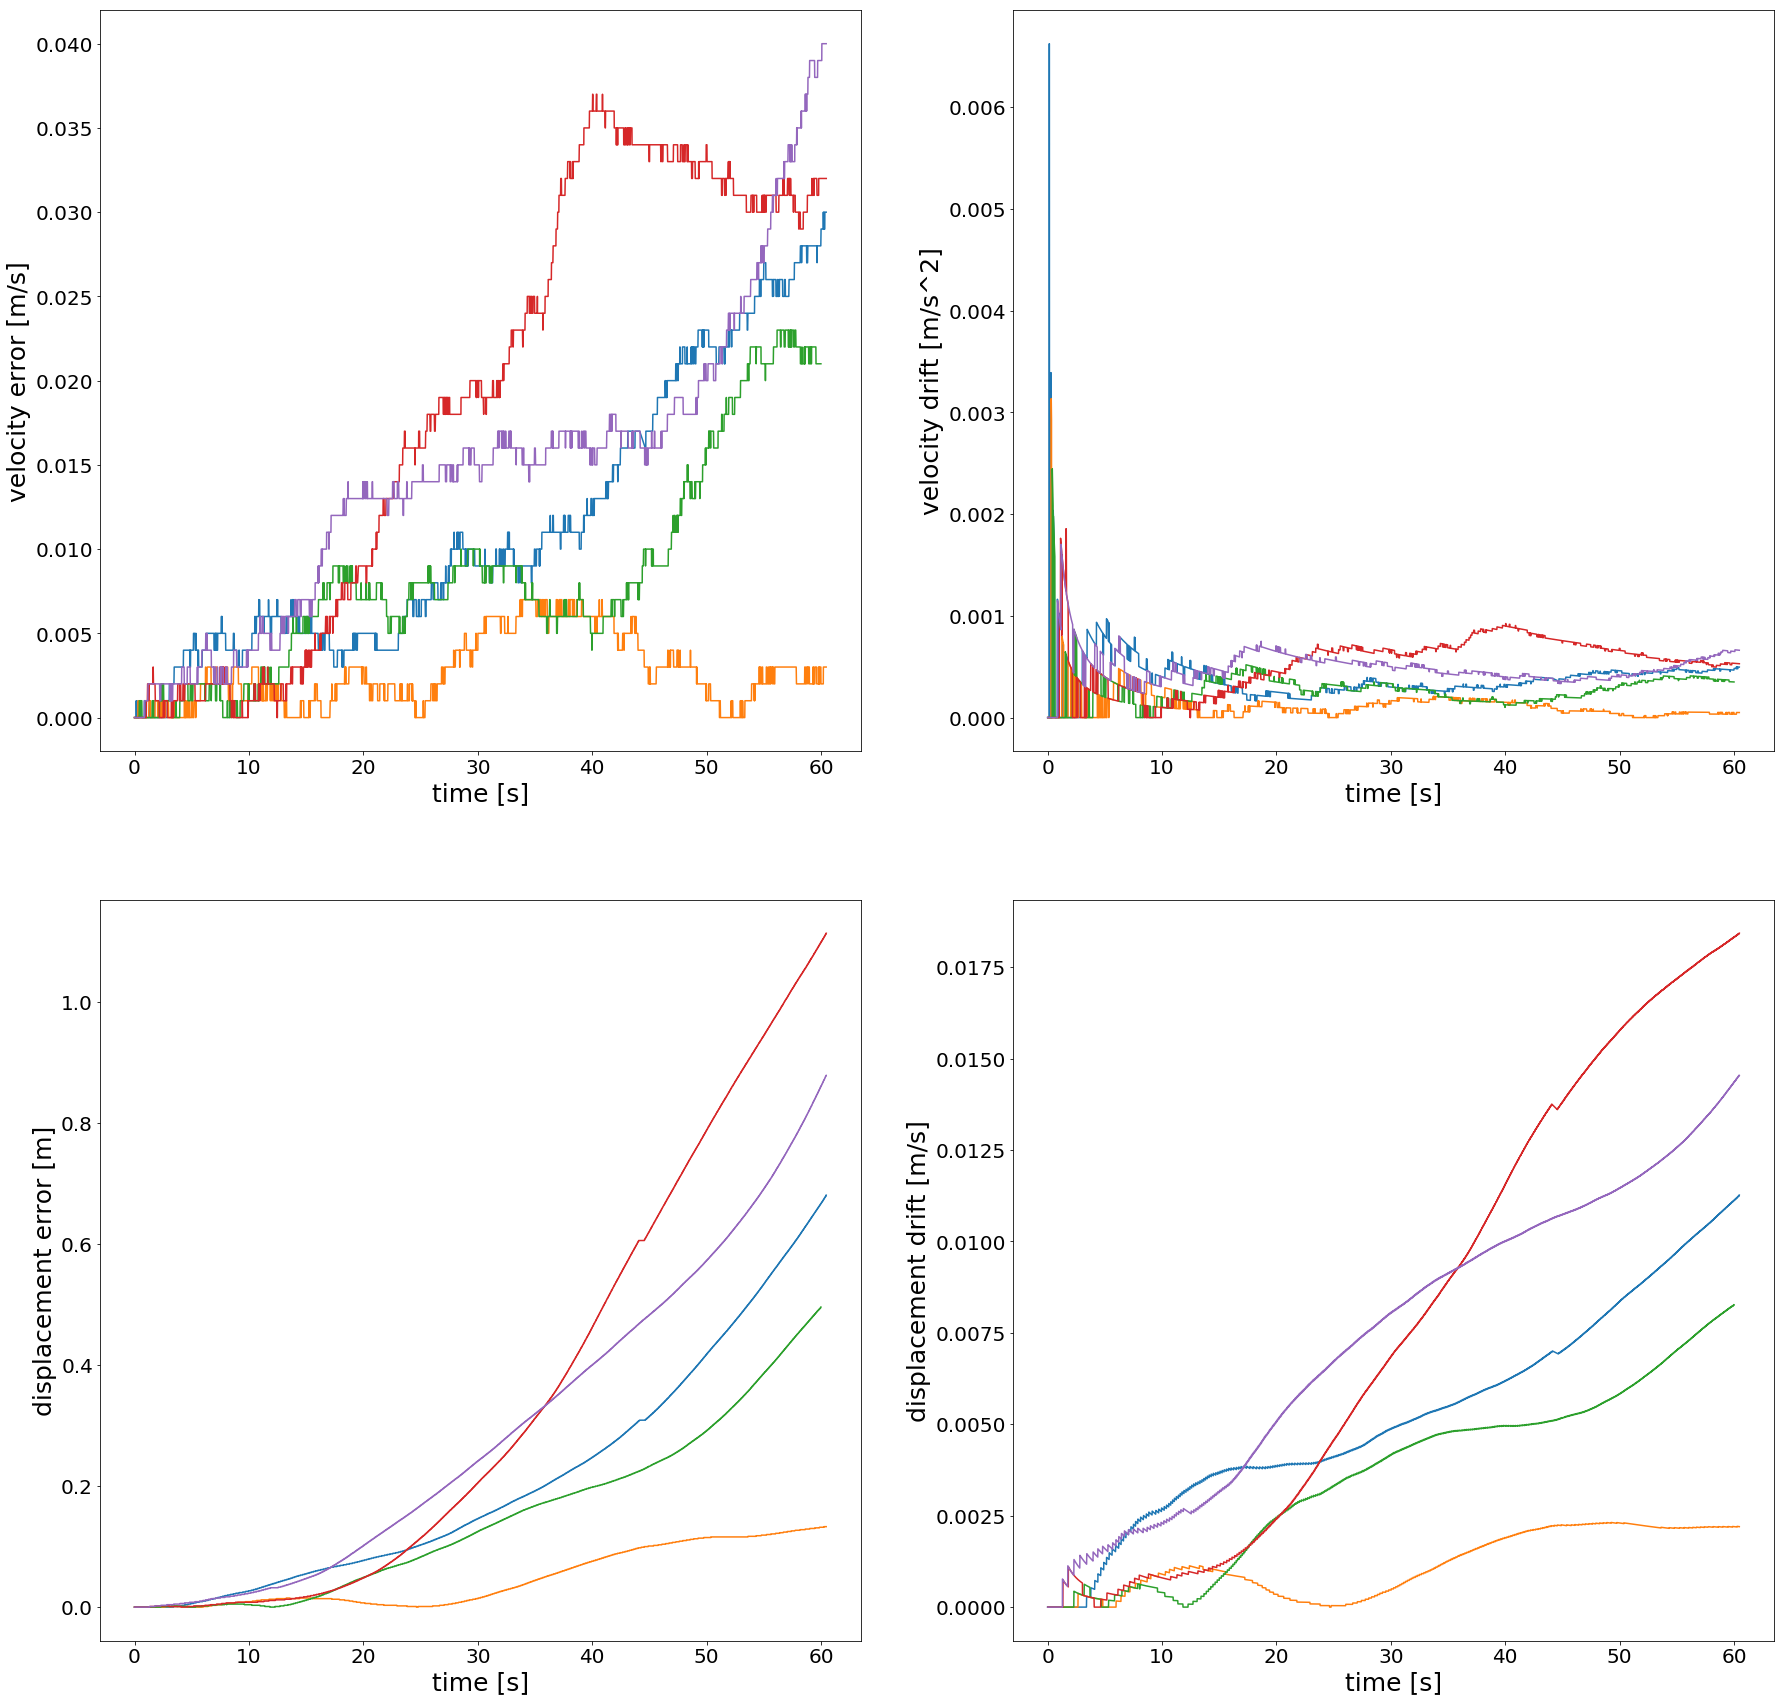

Average drift for stationary experiment


/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


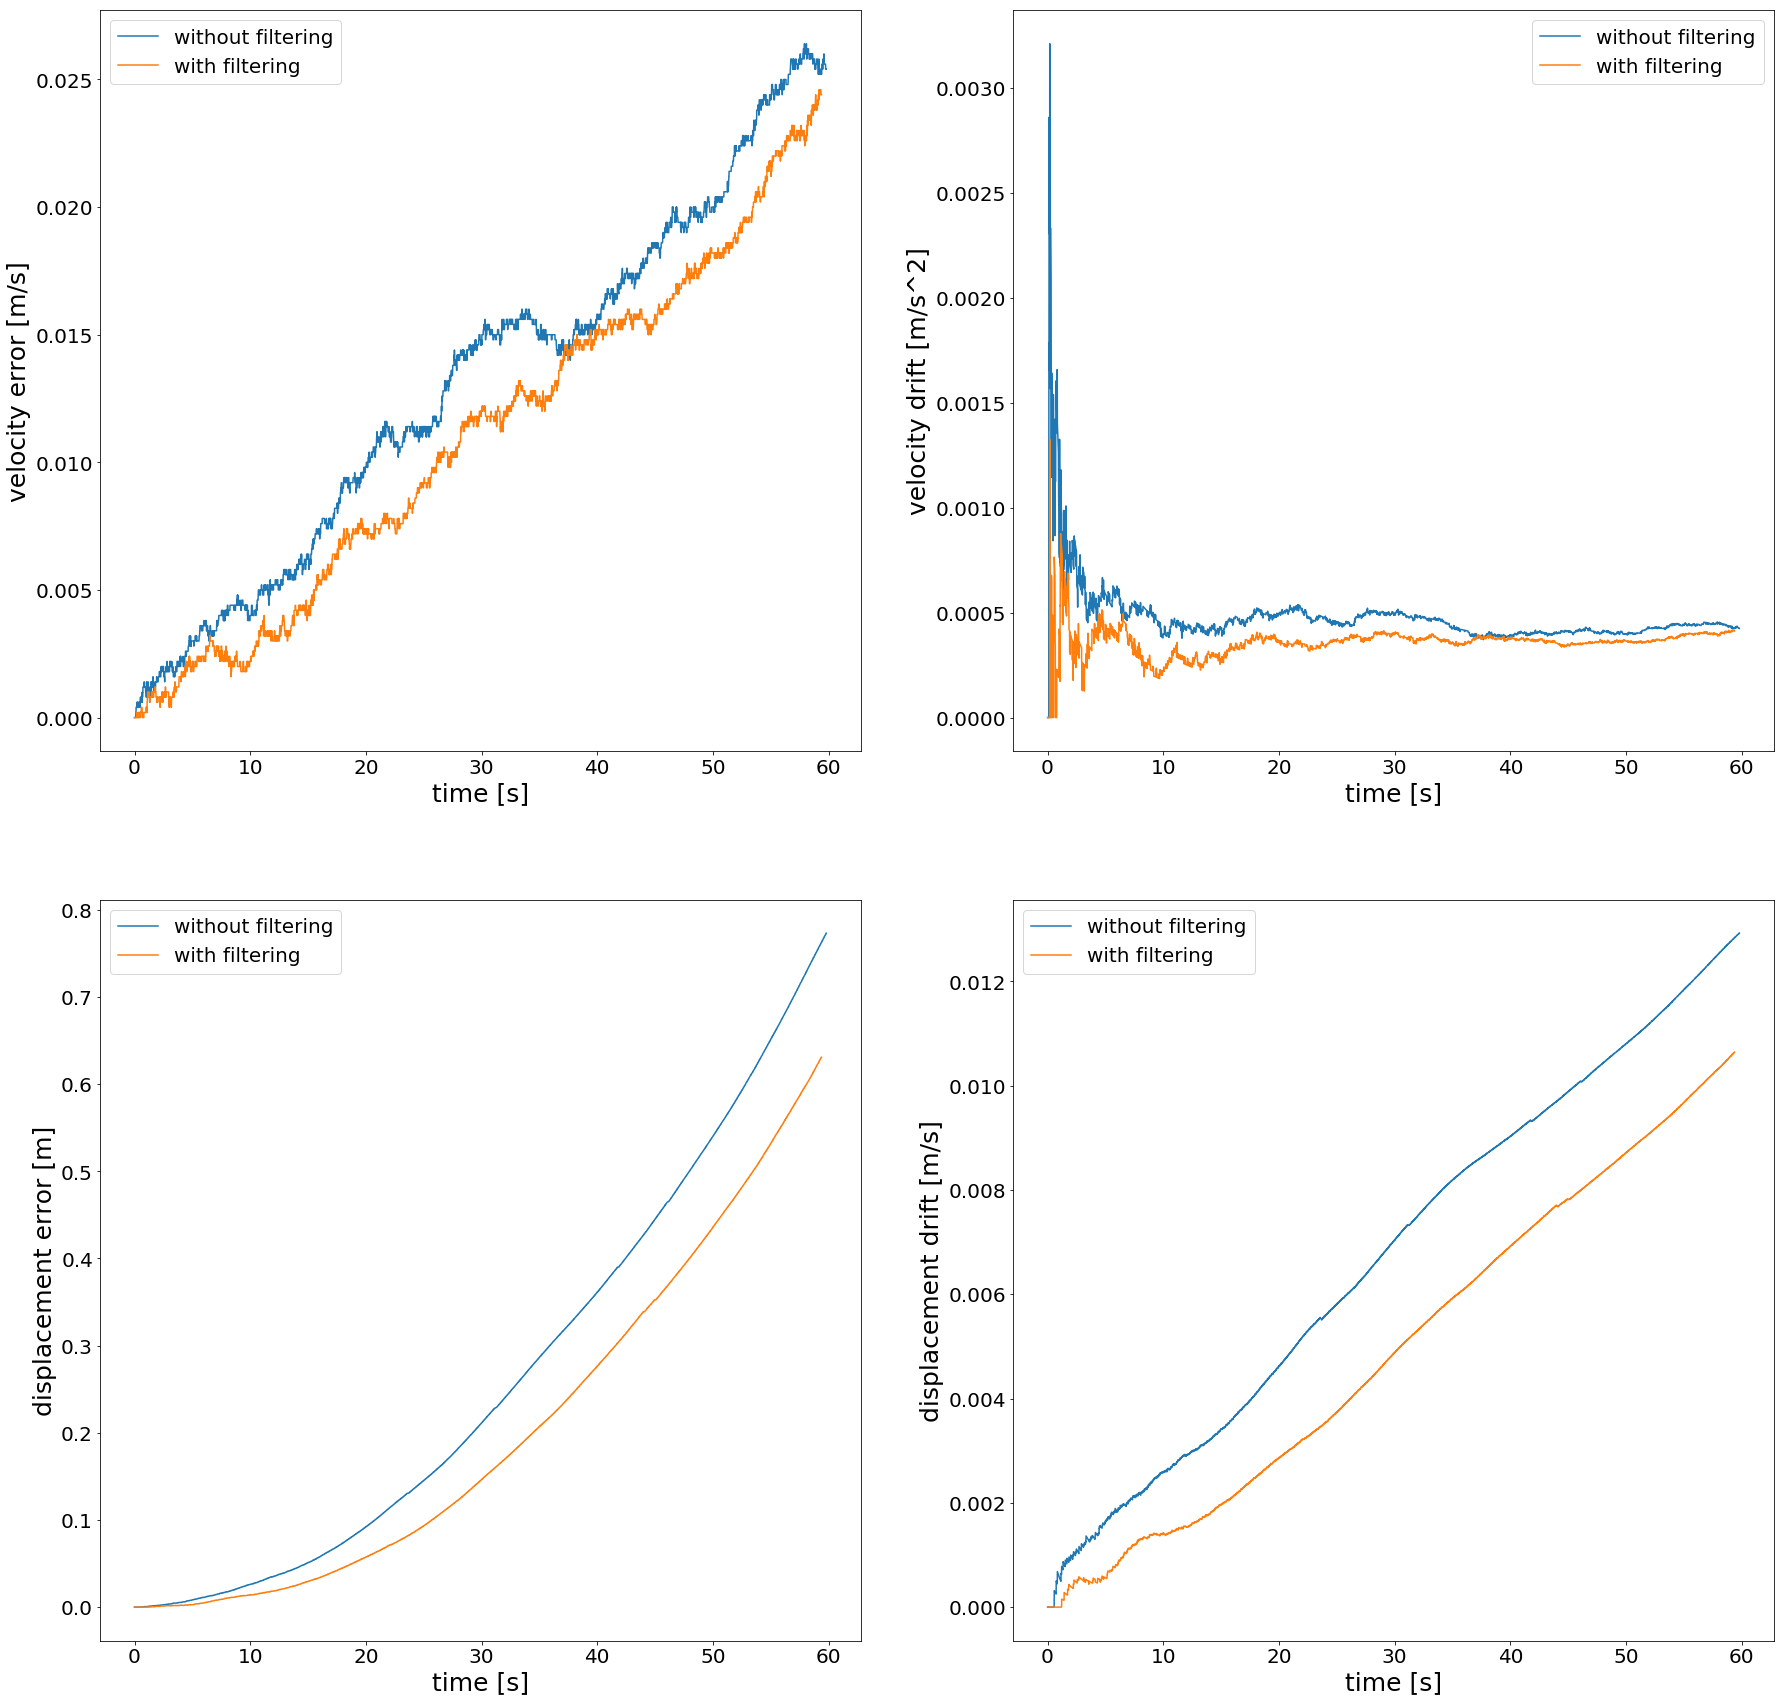

In [7]:
print("Drift for stationary experiment WITHOUT filtering")
plot_drift_data(data_nofilter_sta)
print("Drift for stationary experiment WITH filtering")
plot_drift_data(data_filter_sta)

print("Average drift for stationary experiment")
avg_vel_error, avg_vel_drift, avg_pos_error, avg_pos_drift = plot_drift_data_average([data_nofilter_sta, data_filter_sta])

In [8]:
def fit_poly_order(order, x, y, bias=True):
    """
    fit polynomial with least-square fit
    :param order: max order of polynomial
    :param x: input x
    :param y: target output y
    :return: fitted params
    """
    if bias:
        x_poly = np.array([x**k for k in range(0, order+1)]).T
    else:
        x_poly = np.array([x**k for k in range(1, order+1)]).T
    params = np.linalg.lstsq(x_poly, y, rcond=None)[0]
    return params

def pred_poly_order(order, x, params, bias=True):
    if bias:
        x_poly = np.array([x**k for k in range(0, order+1)]).T
    else:
        x_poly = np.array([x**k for k in range(1, order+1)]).T
    if len(x_poly.shape) == 1:
        x_poly = np.expand_dims(x_poly, axis=-1)
    return np.dot(x_poly, params)

Velocity error linear fit without filtering: 0.00043 t
Velocity error linear fit with filtering: 0.00037 t


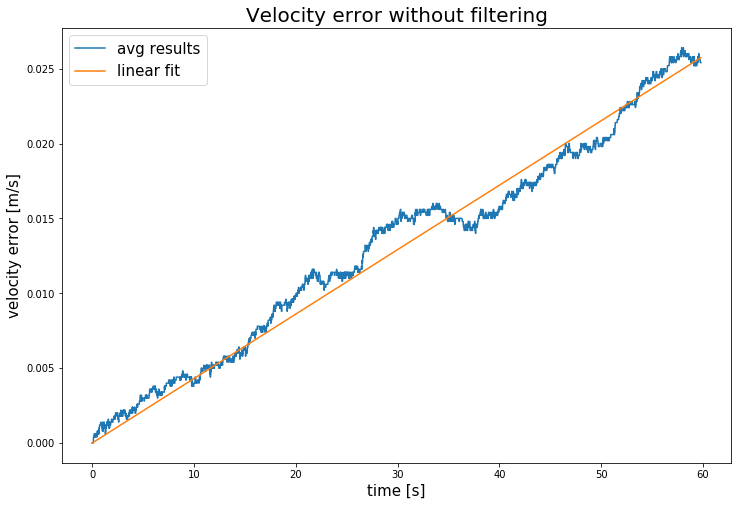

Predicted velocity error after 5mins without filtering: 0.12909 m/s



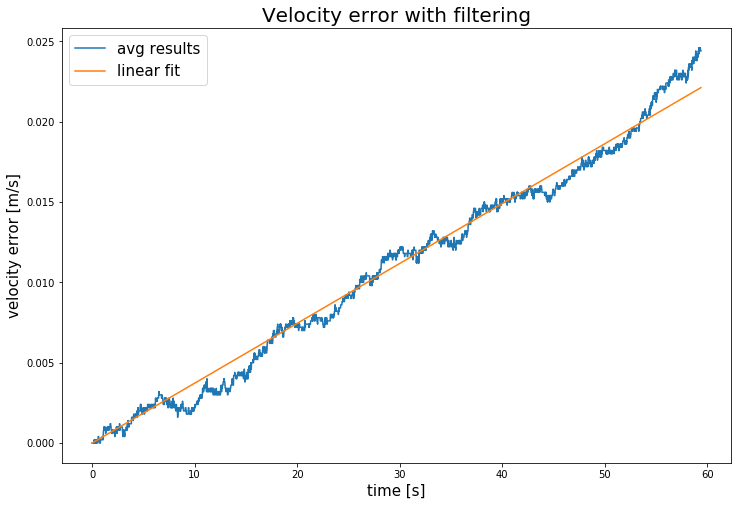

Predicted velocity error after 5mins with filtering: 0.11170 m/s


In [9]:
# fit with(out) filtering
# fit linear polynomial to velocity error over time
# without filtering
time_nofilter, avg_vel_err_nofilter = avg_vel_error[0]
vel_error_nofilter_params = fit_poly_order(1, time_nofilter, avg_vel_err_nofilter, bias=False)
print("Velocity error linear fit without filtering: %.5f t" % vel_error_nofilter_params[0])
pred_nofilter = pred_poly_order(1, time_nofilter, vel_error_nofilter_params, bias=False)

# with filtering
time_filter, avg_vel_err_filter = avg_vel_error[1]
vel_error_filter_params = fit_poly_order(1, time_filter, avg_vel_err_filter, bias=False)
print("Velocity error linear fit with filtering: %.5f t" % vel_error_filter_params[0])
pred_filter = pred_poly_order(1, time_filter, vel_error_filter_params, bias=False)

# plot velocity error without filtering
plt.figure(figsize=(12,8))
plt.title('Velocity error without filtering', fontsize=20)
plt.plot(time_nofilter, avg_vel_err_nofilter, label='avg results')
plt.plot(time_nofilter, pred_nofilter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('velocity error [m/s]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict velocity error over 300s without filtering
time_5min = np.arange(0, 300, 0.1)
pred_vel_err_nofilter_5min = pred_poly_order(1, time_5min, vel_error_nofilter_params, bias=False)
print("Predicted velocity error after 5mins without filtering: %.5f m/s" % pred_vel_err_nofilter_5min[-1])
print()

# plot velocity error with filtering
plt.figure(figsize=(12,8))
plt.title('Velocity error with filtering', fontsize=20)
plt.plot(time_filter, avg_vel_err_filter, label='avg results')
plt.plot(time_filter, pred_filter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('velocity error [m/s]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict velocity error over 300s with filtering
pred_vel_err_filter_5min = pred_poly_order(1, time_5min, vel_error_filter_params, bias=False)
print("Predicted velocity error after 5mins with filtering: %.5f m/s" % pred_vel_err_filter_5min[-1])

/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


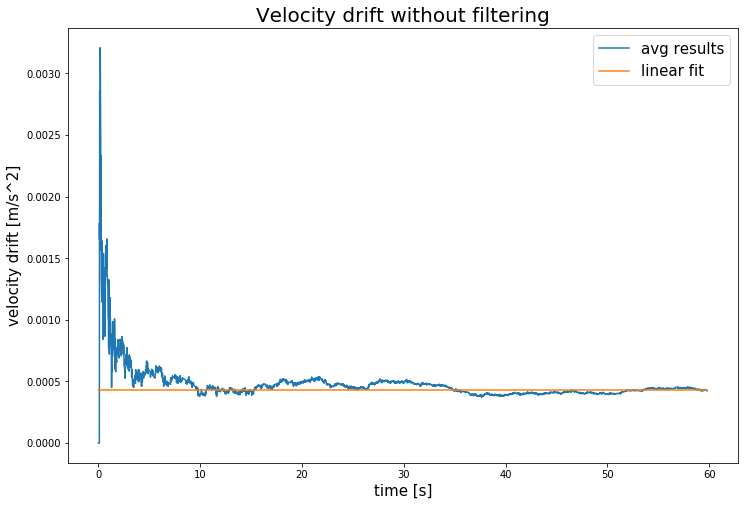

Predicted velocity drift after 5mins without filtering: 0.00043 m/s^2



/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


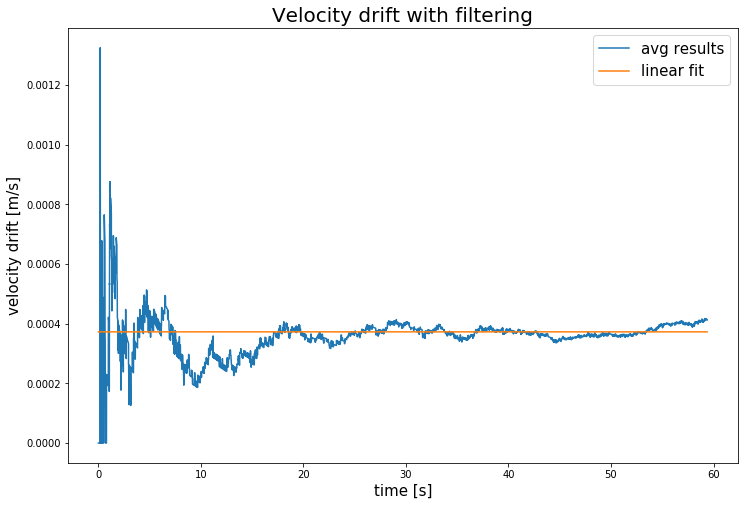

Predicted velocity drift after 5mins with filtering: 0.00037 m/s^2


In [10]:
# divide the predicted error to obtain predicted drift and compare with actual drift
# without filtering
time_nofilter, avg_vel_dri_nofilter = avg_vel_drift[0]
pred_nofilter = pred_poly_order(1, time_nofilter, vel_error_nofilter_params, bias=False)

# with filtering
time_filter, avg_vel_dri_filter = avg_vel_drift[1]
pred_filter = pred_poly_order(1, time_filter, vel_error_filter_params, bias=False)

# plot velocity drift without filtering
plt.figure(figsize=(12,8))
plt.title('Velocity drift without filtering', fontsize=20)
plt.plot(time_nofilter, avg_vel_dri_nofilter, label='avg results')
plt.plot(time_nofilter, pred_nofilter / time_nofilter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('velocity drift [m/s^2]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict velocity drift over 300s without filtering
time_5min = np.arange(0, 300, 0.1)
pred_vel_dri_nofilter_5min = pred_poly_order(1, time_5min, vel_error_nofilter_params, bias=False)
print("Predicted velocity drift after 5mins without filtering: %.5f m/s^2" % (pred_vel_dri_nofilter_5min[-1]/float(time_5min[-1])))
print()

# plot velocity drift with filtering
plt.figure(figsize=(12,8))
plt.title('Velocity drift with filtering', fontsize=20)
plt.plot(time_filter, avg_vel_dri_filter, label='avg results')
plt.plot(time_filter, pred_filter / time_filter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('velocity drift [m/s]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict velocity drift over 300s with filtering
pred_vel_dri_filter_5min = pred_poly_order(1, time_5min, vel_error_filter_params, bias=False)
print("Predicted velocity drift after 5mins with filtering: %.5f m/s^2" % (pred_vel_dri_filter_5min[-1]/float(time_5min[-1])))

Displacement error quadratic fit without filtering: 0.00088 t + 0.00020 t^2
Displacement error quadratic fit with filtering: -0.00089 t + 0.00019 t^2


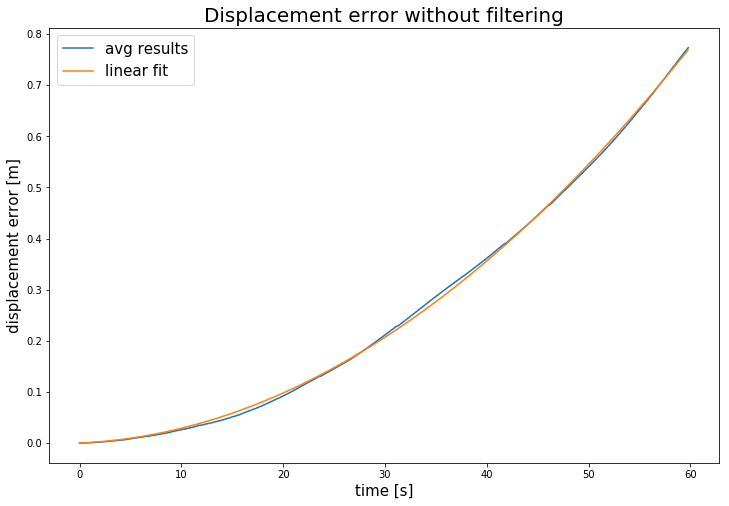

Predicted displacement error after 5mins without filtering: 18.29140 m



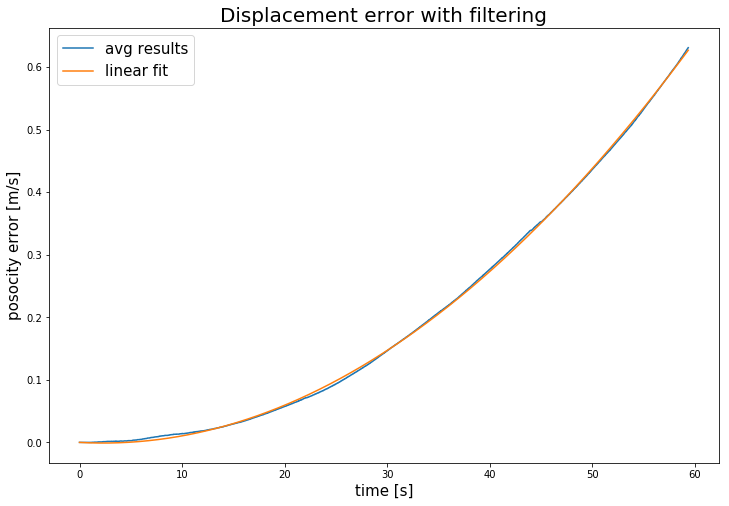

Predicted displacement error after 5mins with filtering: 17.07408 m


In [11]:
# fit with(out) filtering
# fit quadratic polynomial to displacement error over time
# without filtering
time_nofilter, avg_pos_err_nofilter = avg_pos_error[0]
pos_error_nofilter_params = fit_poly_order(2, time_nofilter, avg_pos_err_nofilter, bias=False)
print("Displacement error quadratic fit without filtering: %.5f t + %.5f t^2" % (pos_error_nofilter_params[0], pos_error_nofilter_params[1]))
pred_nofilter = pred_poly_order(2, time_nofilter, pos_error_nofilter_params, bias=False)

# with filtering
time_filter, avg_pos_err_filter = avg_pos_error[1]
pos_error_filter_params = fit_poly_order(2, time_filter, avg_pos_err_filter, bias=False)
print("Displacement error quadratic fit with filtering: %.5f t + %.5f t^2" % (pos_error_filter_params[0], pos_error_filter_params[1]))
pred_filter = pred_poly_order(2, time_filter, pos_error_filter_params, bias=False)

# plot displacement error without filtering
plt.figure(figsize=(12,8))
plt.title('Displacement error without filtering', fontsize=20)
plt.plot(time_nofilter, avg_pos_err_nofilter, label='avg results')
plt.plot(time_nofilter, pred_nofilter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('displacement error [m]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict displacement error over 300s without filtering
time_5min = np.arange(0, 300, 0.1)
pred_pos_err_nofilter_5min = pred_poly_order(2, time_5min, pos_error_nofilter_params, bias=False)
print("Predicted displacement error after 5mins without filtering: %.5f m" % pred_pos_err_nofilter_5min[-1])
print()

# plot displacement error with filtering
plt.figure(figsize=(12,8))
plt.title('Displacement error with filtering', fontsize=20)
plt.plot(time_filter, avg_pos_err_filter, label='avg results')
plt.plot(time_filter, pred_filter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('posocity error [m/s]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict displacement error over 300s with filtering
pred_pos_err_filter_5min = pred_poly_order(2, time_5min, pos_error_filter_params, bias=False)
print("Predicted displacement error after 5mins with filtering: %.5f m" % pred_pos_err_filter_5min[-1])

/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


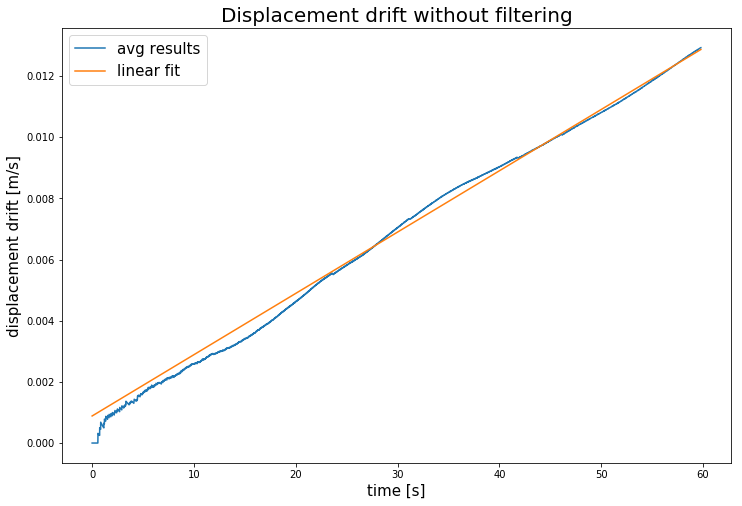

Predicted displacement drift after 5mins without filtering: 0.06099 m/s



/Users/Lukas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


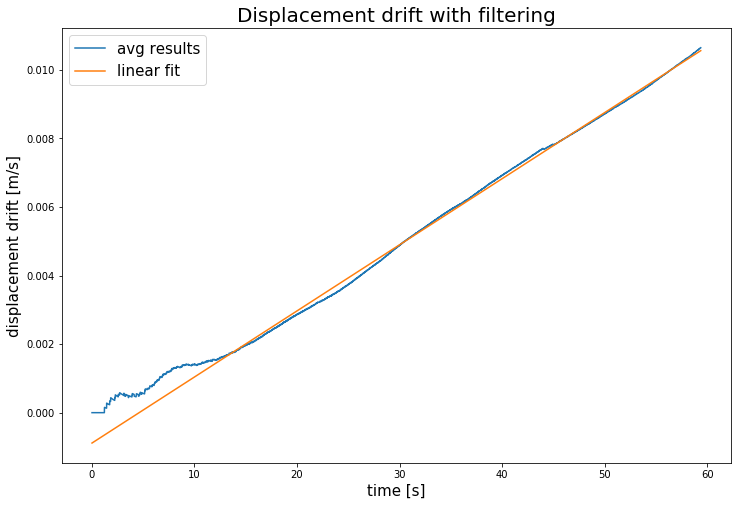

Predicted displacement drift after 5mins with filtering: 0.05693 m/s


In [12]:
# divide the predicted error to obtain predicted drift and compare with actual drift
# without filtering
time_nofilter, avg_pos_dri_nofilter = avg_pos_drift[0]
pred_nofilter = pred_poly_order(2, time_nofilter, pos_error_nofilter_params, bias=False)

# with filtering
time_filter, avg_pos_dri_filter = avg_pos_drift[1]
pred_filter = pred_poly_order(2, time_filter, pos_error_filter_params, bias=False)

# plot displacement drift without filtering
plt.figure(figsize=(12,8))
plt.title('Displacement drift without filtering', fontsize=20)
plt.plot(time_nofilter, avg_pos_dri_nofilter, label='avg results')
plt.plot(time_nofilter, pred_nofilter / time_nofilter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('displacement drift [m/s]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict displacement drift over 300s without filtering
time_5min = np.arange(0, 300, 0.1)
pred_pos_dri_nofilter_5min = pred_poly_order(2, time_5min, pos_error_nofilter_params, bias=False)
print("Predicted displacement drift after 5mins without filtering: %.5f m/s" % (pred_pos_dri_nofilter_5min[-1]/float(time_5min[-1])))
print()

# plot displacement drift with filtering
plt.figure(figsize=(12,8))
plt.title('Displacement drift with filtering', fontsize=20)
plt.plot(time_filter, avg_pos_dri_filter, label='avg results')
plt.plot(time_filter, pred_filter / time_filter, label='linear fit')
plt.xlabel('time [s]', fontsize=15)
plt.ylabel('displacement drift [m/s]', fontsize=15)
plt.legend(prop={'size': 15})

plt.show()

# predict displacement drift over 300s with filtering
pred_pos_dri_filter_5min = pred_poly_order(2, time_5min, pos_error_filter_params, bias=False)
print("Predicted displacement drift after 5mins with filtering: %.5f m/s" % (pred_pos_dri_filter_5min[-1]/float(time_5min[-1])))

In [13]:
def save_plots(run_dicts_lists):
    min_lengths = []
    for run_dicts in run_dicts_lists:
        min_length = None
        for run_dict in run_dicts:
            acc = extract_acc(run_dict)
            if min_length is None or len(acc) < min_length:
                min_length = len(acc)
        min_lengths.append(min_length)
    
    # plot vel errors over time
    f = plt.figure()
    for i, run_dicts in enumerate(run_dicts_lists):
        vels = []
        times = []
        for run_dict in run_dicts:
            vels.append(np.absolute(extract_vel(run_dict)[:min_lengths[i]]))
            times.append(extract_time(run_dict)[:min_lengths[i]])
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
        plt.plot(np.mean(times, axis=0), np.mean(vels, axis=0), label=l)
        plt.xlabel('time [s]')
        plt.ylabel('velocity error [m/s]')
        plt.legend()
    plt.savefig('stationary_vel_error.pdf', format='pdf', bbox_inches = "tight")
        
    # plot vel drift over time
    f = plt.figure()
    for i, run_dicts in enumerate(run_dicts_lists):
        vals = []
        times = []
        for run_dict in run_dicts:
            vel = extract_vel(run_dict)[:min_lengths[i]]
            time = extract_time(run_dict)[:min_lengths[i]]
            vals.append(np.absolute(vel/time))
            times.append(time)
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
        plt.plot(np.mean(times, axis=0), np.mean(vals, axis=0), label=l)
        plt.xlabel('time [s]')
        plt.ylabel('velocity drift [m/s^2]')
        plt.legend()
    plt.savefig('stationary_vel_drift.pdf', format='pdf', bbox_inches = "tight")

    # plot pos errors over time
    f = plt.figure()
    for i, run_dicts in enumerate(run_dicts_lists):
        poss = []
        times = []
        for run_dict in run_dicts:
            poss.append(np.absolute(extract_pos(run_dict)[:min_lengths[i]]))
            times.append(extract_time(run_dict)[:min_lengths[i]])
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
        plt.plot(np.mean(times, axis=0), np.mean(poss, axis=0), label=l)
        plt.xlabel('time [s]')
        plt.ylabel('displacement error [m]')
        plt.legend()
    plt.savefig('stationary_dis_error.pdf', format='pdf', bbox_inches = "tight")
        
    # plot pos drift over time
    f = plt.figure()
    for i, run_dicts in enumerate(run_dicts_lists):
        vals = []
        times = []
        for run_dict in run_dicts:
            pos = extract_pos(run_dict)[:min_lengths[i]]
            time = extract_time(run_dict)[:min_lengths[i]]
            vals.append(np.absolute(pos/time))
            times.append(time)
        if i == 0:
            l = 'without filtering'
        else:
            l = 'with filtering'
        plt.plot(np.mean(times, axis=0), np.mean(vals, axis=0), label=l)
        plt.xlabel('time [s]')
        plt.ylabel('displacement drift [m/s]')
        plt.legend()
    plt.savefig('stationary_dis_drift.pdf', format='pdf', bbox_inches = "tight")
    plt.show()

In [14]:
# save_plots([data_nofilter_sta, data_filter_sta])